In [123]:
import argparse
import logging
import time

import torch
import torchtext
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.prototype.transforms import load_sp_model, PRETRAINED_SP_MODEL, SentencePieceTokenizer
from torchtext.utils import download_from_url
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torchtext.vocab import GloVe, FastText
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np
import random
from sentence_transformers import SentenceTransformer

In [124]:
# EXPERIMENT SETTING

# embedding method
EMBD = 'GloVe' # choose from 'GloVe' or 'sbert'
# number of classification class - according to different Data Set
NUM_CLASS = 4
# Corruption: if not then concatnate
INSERT = False 

## About Data Set

AG News (AG’s News Corpus) is a subdataset of AG's corpus of news articles constructed by assembling titles and description fields of articles from the 4 largest classes (“World”, “Sports”, “Business”, “Sci/Tech”) of AG’s Corpus.

## Tokenizer
- Different models tolenize in different ways. 
    - Word2Vec / GloVe does words (WordLevel).
    - BERT does WordPiece.
    - The original transformer did BytePairEncoding.
    - FastText uses n-grams.


In [125]:
TOKENIZER = get_tokenizer("basic_english")

## Embedding: GloVE/sbert

In [126]:
# GloVe
GLOVE = GloVe(name='840B', dim=300)
#([6, 300])
GLOVE.get_vecs_by_tokens(TOKENIZER("Hello, How are you?"), lower_case_backup=True) 


# FASTTEXT = FastText()

# sbert
model = SentenceTransformer('all-MiniLM-L6-v2')
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']
embeddings = model.encode(sentences) #([3, 384])

# Forward-Forward Algo

## Dataset - get Positive Samples & Negative Samples

In [127]:
# define collate_fn with embedding method
def vectorize_batch(batch, embed_method = 'GloVe'):
    Y, X = list(zip(*batch))
    X = [TOKENIZER(x) for x in X]
    
    if embed_method == 'GloVe':
      X_tensor = torch.zeros(len(batch), 300)
      for i, tokens in enumerate(X):
          X_tensor[i] = GLOVE.get_vecs_by_tokens(tokens).mean(dim=0) ## Averaging Embedding accross all words of text document
    
    if embed_method == 'sbert': #slow
      X_tensor = torch.from_numpy(model.encode(X))

    return X_tensor, torch.tensor(Y) - 1 

In [128]:
target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

num_train = round(0.95*len(train_dataset))
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

# torch.Size([114000, embed]) torch.Size([114000])
train_loader = DataLoader(split_train_, batch_size=len(split_train_), collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

# torch.Size([6000, embed]) torch.Size([6000])
valid_loader = DataLoader(split_valid_, batch_size=len(split_valid_), collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

# torch.Size([7600, embed]) torch.Size([7600])
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

In [129]:
x_train, y = next(iter(train_loader))
x_train.shape, y.shape

(torch.Size([114000, 300]), torch.Size([114000]))

In [130]:
x_train[:5,:],y[:5]

(tensor([[-0.0421,  0.1912, -0.1017,  ..., -0.1023,  0.0779,  0.1128],
         [ 0.0471,  0.1277, -0.0785,  ..., -0.0851, -0.0511, -0.0470],
         [-0.0251,  0.0793, -0.0117,  ..., -0.0679, -0.0261,  0.1726],
         [ 0.0912,  0.1563, -0.0576,  ...,  0.0051,  0.0223, -0.0458],
         [-0.0985,  0.2043, -0.1233,  ...,  0.0211, -0.0731,  0.0318]]),
 tensor([2, 1, 2, 1, 1]))

In [131]:
def create_pos_neg(x_train, insert = True):
  
  x_pos = x_train.clone().detach()
  x_neg = x_train.clone().detach()

  # if concatenate
  if not insert:
    x_pos = torch.cat((torch.zeros(x_pos.size(0), NUM_CLASS), x_pos), 1)
    x_neg = torch.cat((torch.zeros(x_neg.size(0), NUM_CLASS), x_neg), 1)
  # if insert
  else:
    x_pos[:,0:NUM_CLASS] = torch.zeros(x_pos.size(0), NUM_CLASS)
    x_neg[:,0:NUM_CLASS] = torch.zeros(x_neg.size(0), NUM_CLASS)

  y_ = torch.randint(0,NUM_CLASS,(x_neg.size(0),))

  for i in range(x_neg.size(0)):
    x_pos[i,y[i]] = 1
    # x_neg[i,y_[i]] = 1
    # # NOTE: y_[i] maybe the right label, which will certainly hurt experiment results!
    if y_[i] != y[i]:
      x_neg[i,y_[i]] = 1
    else:
      x_neg[i,(y[i]+1)%NUM_CLASS] = 1
  
  return x_pos, x_neg

In [132]:
x_pos, x_neg = create_pos_neg(x_train, insert=INSERT)
embed_len = x_pos.shape[1]
embed_len

304

In [133]:
print(x_pos[:5,:])
print(x_neg[:5,:])

tensor([[ 0.0000,  0.0000,  1.0000,  ..., -0.1023,  0.0779,  0.1128],
        [ 0.0000,  1.0000,  0.0000,  ..., -0.0851, -0.0511, -0.0470],
        [ 0.0000,  0.0000,  1.0000,  ..., -0.0679, -0.0261,  0.1726],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0051,  0.0223, -0.0458],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0211, -0.0731,  0.0318]])
tensor([[ 0.0000,  1.0000,  0.0000,  ..., -0.1023,  0.0779,  0.1128],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0851, -0.0511, -0.0470],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0679, -0.0261,  0.1726],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0051,  0.0223, -0.0458],
        [ 0.0000,  0.0000,  1.0000,  ...,  0.0211, -0.0731,  0.0318]])


## Model

In [134]:
layer_epoch = 1000
layer_threshold = 5  #2.0

class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = layer_threshold
        self.num_epochs = layer_epoch

    def forward(self, x):
        x_direction = x / (x.norm(p = 2, dim = 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            # torch.Size([114000, embed]) --> torch.Size([114000])
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            # The following loss pushes pos (neg) samples to
            # values larger (smaller) than the self.threshold.

            # after exp()  torch.Size([228000])
            # loss torch.size([1])
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()

            self.opt.zero_grad()
            # this backward just compute the derivative and hence
            # is not considered backpropagation.
            loss.backward()
            self.opt.step()

            if i % 100 == 0 and i > 0:
              print(
                "| epoch {:3d} | loss {:8.3f}".format(i, loss)
              )
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [135]:
class Net(torch.nn.Module):

    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1])]
        print(self.layers)

    def predict(self, x):
        goodness_per_label = []
        for label in range(NUM_CLASS):
            h = x.clone().detach()
            if INSERT:
              h[:, 0:NUM_CLASS] = torch.zeros(x.size(0), NUM_CLASS)
            else:
              h = torch.cat((torch.zeros(x.size(0), NUM_CLASS), h), dim = 1)
            h[:, label] = 1      
            # 4 , x.size(0)      
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]

            goodness_per_label += [sum(goodness).unsqueeze(1)]
        # [torch(x.size(0)),torch(x.size(0)),torch(x.size(0)),torch(x.size(0))]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        # print(goodness_per_label.shape)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print("-" * 59)
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)
            print("-" * 59)

## Train the model

In [136]:
net = Net([embed_len, 256, 128, 64, len(target_classes)])
net.train(x_pos, x_neg)

[Layer(
  in_features=304, out_features=256, bias=True
  (relu): ReLU()
), Layer(
  in_features=256, out_features=128, bias=True
  (relu): ReLU()
), Layer(
  in_features=128, out_features=64, bias=True
  (relu): ReLU()
), Layer(
  in_features=64, out_features=4, bias=True
  (relu): ReLU()
)]
-----------------------------------------------------------
training layer 0 ...


 10%|█         | 101/1000 [01:05<09:39,  1.55it/s]

| epoch 100 | loss    0.690


 20%|██        | 201/1000 [02:11<08:54,  1.50it/s]

| epoch 200 | loss    0.531


 30%|███       | 301/1000 [03:17<08:18,  1.40it/s]

| epoch 300 | loss    0.386


 40%|████      | 401/1000 [04:22<06:31,  1.53it/s]

| epoch 400 | loss    0.308


 50%|█████     | 501/1000 [05:27<05:17,  1.57it/s]

| epoch 500 | loss    0.267


 60%|██████    | 601/1000 [06:32<04:20,  1.53it/s]

| epoch 600 | loss    0.243


 70%|███████   | 701/1000 [07:37<03:15,  1.53it/s]

| epoch 700 | loss    0.228


 80%|████████  | 801/1000 [08:42<02:09,  1.53it/s]

| epoch 800 | loss    0.218


 90%|█████████ | 901/1000 [09:47<01:05,  1.51it/s]

| epoch 900 | loss    0.211


100%|██████████| 1000/1000 [10:52<00:00,  1.53it/s]


-----------------------------------------------------------
-----------------------------------------------------------
training layer 1 ...


 10%|█         | 101/1000 [00:28<04:18,  3.48it/s]

| epoch 100 | loss    0.482


 20%|██        | 201/1000 [00:56<03:41,  3.61it/s]

| epoch 200 | loss    0.298


 30%|███       | 301/1000 [01:26<03:13,  3.62it/s]

| epoch 300 | loss    0.269


 40%|████      | 401/1000 [01:54<02:43,  3.66it/s]

| epoch 400 | loss    0.255


 50%|█████     | 501/1000 [02:22<02:19,  3.57it/s]

| epoch 500 | loss    0.247


 60%|██████    | 601/1000 [02:49<01:50,  3.60it/s]

| epoch 600 | loss    0.240


 70%|███████   | 701/1000 [03:17<01:21,  3.67it/s]

| epoch 700 | loss    0.234


 80%|████████  | 801/1000 [03:45<01:00,  3.31it/s]

| epoch 800 | loss    0.230


 90%|█████████ | 901/1000 [04:12<00:27,  3.57it/s]

| epoch 900 | loss    0.226


100%|██████████| 1000/1000 [04:40<00:00,  3.57it/s]


-----------------------------------------------------------
-----------------------------------------------------------
training layer 2 ...


 10%|█         | 102/1000 [00:11<01:40,  8.94it/s]

| epoch 100 | loss    0.479


 20%|██        | 202/1000 [00:22<01:30,  8.87it/s]

| epoch 200 | loss    0.454


 30%|███       | 302/1000 [00:33<01:16,  9.07it/s]

| epoch 300 | loss    0.434


 40%|████      | 402/1000 [00:45<01:07,  8.82it/s]

| epoch 400 | loss    0.419


 50%|█████     | 502/1000 [00:56<00:55,  8.94it/s]

| epoch 500 | loss    0.407


 60%|██████    | 602/1000 [01:07<00:44,  9.01it/s]

| epoch 600 | loss    0.397


 70%|███████   | 702/1000 [01:18<00:33,  8.95it/s]

| epoch 700 | loss    0.388


 80%|████████  | 802/1000 [01:29<00:21,  9.05it/s]

| epoch 800 | loss    0.381


 90%|█████████ | 902/1000 [01:41<00:10,  9.03it/s]

| epoch 900 | loss    0.374


100%|██████████| 1000/1000 [01:52<00:00,  8.93it/s]


-----------------------------------------------------------
-----------------------------------------------------------
training layer 3 ...


 10%|█         | 105/1000 [00:02<00:22, 39.23it/s]

| epoch 100 | loss    0.614


 21%|██        | 206/1000 [00:05<00:19, 40.26it/s]

| epoch 200 | loss    0.611


 31%|███       | 307/1000 [00:07<00:17, 39.22it/s]

| epoch 300 | loss    0.608


 40%|████      | 405/1000 [00:10<00:15, 39.14it/s]

| epoch 400 | loss    0.605


 50%|█████     | 505/1000 [00:12<00:12, 39.47it/s]

| epoch 500 | loss    0.603


 61%|██████    | 608/1000 [00:15<00:09, 39.59it/s]

| epoch 600 | loss    0.601


 71%|███████   | 709/1000 [00:18<00:07, 37.67it/s]

| epoch 700 | loss    0.598


 81%|████████  | 809/1000 [00:20<00:04, 39.63it/s]

| epoch 800 | loss    0.596


 91%|█████████ | 908/1000 [00:23<00:02, 39.77it/s]

| epoch 900 | loss    0.594


100%|██████████| 1000/1000 [00:25<00:00, 39.21it/s]

-----------------------------------------------------------


In [137]:
print('train acc:', net.predict(x_train).eq(y).float().mean().item())

train acc: 0.8902368545532227


## Prediction

In [138]:
x_test, Y_actual = next(iter(train_loader))
Y_preds = net.predict(x_test)

In [139]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8902368421052631

Classification Report : 
              precision    recall  f1-score   support

       World       0.92      0.87      0.90     28528
      Sports       0.93      0.98      0.96     28423
    Business       0.83      0.87      0.85     28534
    Sci/Tech       0.87      0.84      0.86     28515

    accuracy                           0.89    114000
   macro avg       0.89      0.89      0.89    114000
weighted avg       0.89      0.89      0.89    114000


Confusion Matrix : 
[[24870  1075  1649   934]
 [  260 27830   188   145]
 [  856   411 24849  2418]
 [  925   480  3172 23938]]


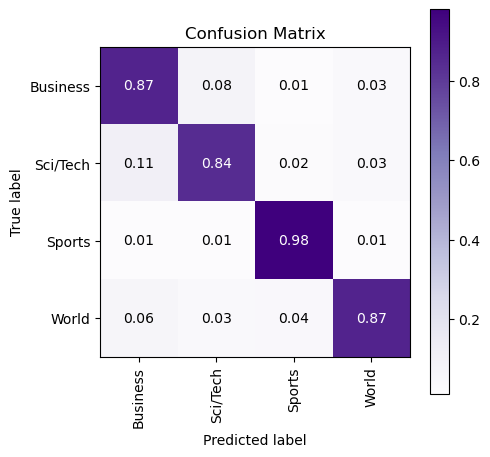

In [140]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

# Baseline

## Dataset

In [141]:
# define collate_fn with embedding method
def vectorize_batch(batch, embed_method = 'GloVe'):
    Y, X = list(zip(*batch))
    X = [TOKENIZER(x) for x in X]
    
    if embed_method == 'GloVe':
      X_tensor = torch.zeros(len(batch), 300)
      for i, tokens in enumerate(X):
          X_tensor[i] = GLOVE.get_vecs_by_tokens(tokens).mean(dim=0) ## Averaging Embedding accross all words of text document
    
    if embed_method == 'sbert': #slow
      X_tensor = torch.from_numpy(model.encode(X))

    return X_tensor, torch.tensor(Y) - 1 


target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

num_train = round(0.95*len(train_dataset))
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_loader = DataLoader(split_train_, batch_size=1024, collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))
valid_loader = DataLoader(split_valid_, batch_size=1024, collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))
test_loader = DataLoader(test_dataset, batch_size=1024, collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

In [142]:
for X, Y in train_loader:
    print(X)
    print(X.shape, Y.shape)
    break

tensor([[ 0.0754,  0.1507, -0.0853,  ..., -0.0506, -0.0121, -0.0769],
        [-0.1080,  0.1522,  0.0060,  ..., -0.1904, -0.0234,  0.2411],
        [-0.0853,  0.0885,  0.1069,  ..., -0.0681, -0.0925,  0.0763],
        ...,
        [ 0.0511,  0.1253, -0.0645,  ..., -0.0036,  0.0241,  0.0201],
        [ 0.0185,  0.1185,  0.0468,  ..., -0.2462,  0.0511,  0.1464],
        [ 0.0282,  0.1421, -0.0337,  ..., -0.0240,  0.0511,  0.0083]])
torch.Size([1024, 300]) torch.Size([1024])


In [143]:
embed_len = X.shape[1]
embed_len

300

## Model

In [144]:
class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(embed_len, 256),
            nn.ReLU(),

            nn.Linear(256,128),
            nn.ReLU(),

            nn.Linear(128,64),
            nn.ReLU(),

            nn.Linear(64, len(target_classes)),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

## Train the model

In [145]:
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))

In [146]:
def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            # X: Batch_size x (25*300)
            # Y: Batch_size x 1
            # Y_preds: Batch_size x num_class
            Y_preds = model(X) 

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if i%5==0:
            print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
            print("Train Acc  : {:.3f}".format(accuracy_score(Y.numpy(), Y_preds.argmax(dim=-1).numpy())))
            CalcValLossAndAccuracy(model, loss_fn, val_loader)

In [147]:
epochs = 25
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
embed_classifier = EmbeddingClassifier()
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

TrainModel(embed_classifier, loss_fn, optimizer, train_loader, valid_loader, epochs)

100%|██████████| 112/112 [00:15<00:00,  7.26it/s]


Train Loss : 0.264
Train Acc  : 0.929
Valid Loss : 0.286
Valid Acc  : 0.902


100%|██████████| 112/112 [00:15<00:00,  7.13it/s]


Train Loss : 0.226
Train Acc  : 0.943
Valid Loss : 0.259
Valid Acc  : 0.908


100%|██████████| 112/112 [00:15<00:00,  7.24it/s]


Train Loss : 0.198
Train Acc  : 0.955
Valid Loss : 0.254
Valid Acc  : 0.909


100%|██████████| 112/112 [00:15<00:00,  7.19it/s]


Train Loss : 0.176
Train Acc  : 0.967
Valid Loss : 0.257
Valid Acc  : 0.912


100%|██████████| 112/112 [00:15<00:00,  7.26it/s]


Train Loss : 0.152
Train Acc  : 0.979
Valid Loss : 0.267
Valid Acc  : 0.911


## Prediction

In [148]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(embed_classifier, test_loader)

In [149]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.9156578947368421

Classification Report : 
              precision    recall  f1-score   support

       World       0.93      0.92      0.92      1900
      Sports       0.96      0.98      0.97      1900
    Business       0.92      0.83      0.87      1900
    Sci/Tech       0.86      0.93      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600


Confusion Matrix : 
[[1746   45   60   49]
 [  18 1861   13    8]
 [  82   13 1581  224]
 [  40   18   71 1771]]


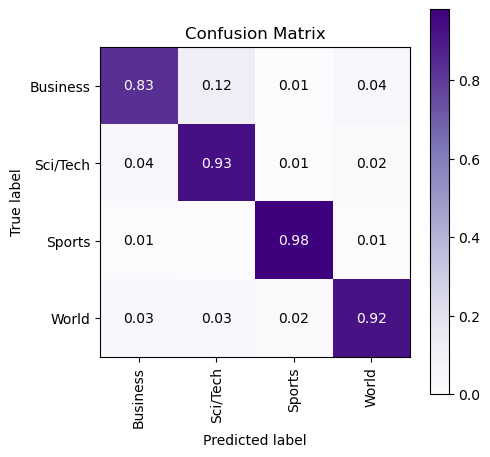

In [150]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);